Simple conway game of life rules on GPU

In [11]:
import torch
import numpy as np
import os

import matplotlib.pyplot as plt

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "caching_allocator"

In [95]:
torch.cuda.is_available()
cuda = torch.device('cuda')
cpu = torch.device('cpu')


In [96]:
canvas = torch.randint(0, 2, (100, 100), device=cuda, dtype=torch.int)

In [97]:
canvas.to(cpu)

tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 0, 1, 0]], dtype=torch.int32)

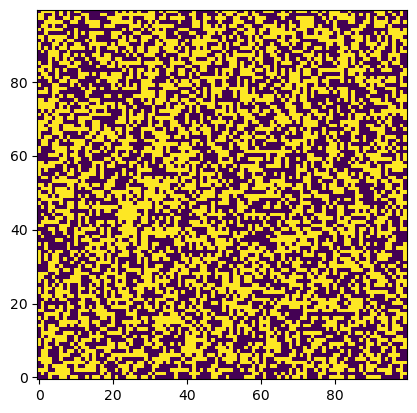

In [98]:
plt.imshow(canvas.to(cpu), origin="lower")

In [99]:
torch.roll(canvas, -1, dims=0)

tensor([[0, 1, 0,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        [0, 0, 1,  ..., 0, 1, 0],
        ...,
        [1, 1, 0,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0]], device='cuda:0', dtype=torch.int32)

In [47]:
canvas.device

device(type='cuda', index=0)

In [177]:
def calc_shifted(intensor):
    """shifted up, down, left, right"""
    out_size = (*tuple(intensor.shape), 4)
    output = torch.zeros(out_size, dtype=intensor.dtype, device=intensor.device)   
    output[:, :, 0] = torch.roll(intensor, shifts=-1, dims=0)
    output[:, :, 1] = torch.roll(intensor, shifts=1, dims=0)
    output[:, :, 2] = torch.roll(intensor, shifts=-1, dims=1)
    output[:, :, 3] = torch.roll(intensor, shifts=1, dims=1)
    return output
    
def calc_unshifted(intensor):
    out_size = (*tuple(intensor.shape), 4)
    output = torch.zeros(out_size, dtype=intensor.dtype, device=intensor.device)   
    output[:, :, 0] = torch.roll(intensor, shifts=1, dims=0)
    output[:, :, 1] = torch.roll(intensor, shifts=-1, dims=0)
    output[:, :, 2] = torch.roll(intensor, shifts=1, dims=1)
    output[:, :, 3] = torch.roll(intensor, shifts=-1, dims=1)
    return output

def center_cut(intensor):
    output = intensor[1:-1, 1:-1]
    return output
    
def center_cut_dd(intensor):
    output = intensor[1:-1, 1:-1, :]
    return output
    
def null_edges(intensor):
    intensor[0, :] = 0
    intensor[:, 0] = 0
    intensor[:, -1] = 0
    intensor[-1, :] = 0
    return intensor


def pad(canvas):
    """Warning, torch pad has a really strange syntax"""
    arr = torch.nn.functional.pad(canvas, (1, 1, 1, 1), mode="constant", value=0)
    return arr

In [178]:
canvas = torch.randint(0, 2, (10, 10), device=cuda, dtype=torch.int)

In [179]:
canvas.shape

torch.Size([10, 10])

In [180]:
pad(canvas).shape

torch.Size([12, 12])

In [203]:
canvas

tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
        [1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
        [0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
        [1, 0, 0, 1, 1, 1, 0, 0, 1, 0]], device='cuda:0', dtype=torch.int32)

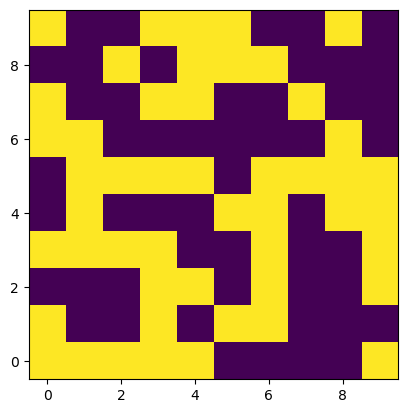

In [181]:
plt.imshow(canvas.to(cpu), origin="lower")

In [184]:
tens = center_cut_dd(calc_shifted(pad(canvas)))

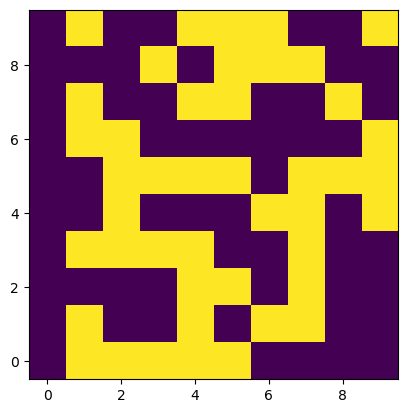

In [194]:
plt.imshow(tens[:, :, 3].to(cpu), origin="lower")

In [ ]:
center_cut_dd(calc_shifted(pad(canvas)))

In [198]:
neighbors = center_cut_dd(calc_shifted(pad(canvas)))
envsum = neighbors.sum(dim=-1)

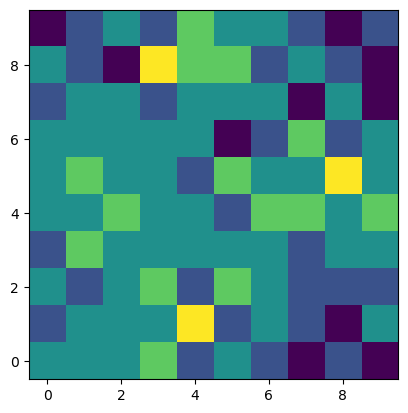

In [199]:
plt.imshow(envsum.to(cpu), origin="lower")

    Any live cell with fewer than two live neighbours dies, as if by underpopulation.
    Any live cell with two or three live neighbours lives on to the next generation.
    Any live cell with more than three live neighbours dies, as if by overpopulation.
    Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

In [324]:
envsum

tensor([[2, 2, 2, 3, 1, 2, 1, 0, 1, 0],
        [1, 2, 2, 2, 4, 1, 2, 1, 0, 2],
        [2, 1, 2, 3, 1, 3, 2, 1, 1, 1],
        [1, 3, 2, 2, 2, 2, 2, 1, 2, 2],
        [2, 2, 3, 2, 2, 1, 3, 3, 2, 3],
        [2, 3, 2, 2, 1, 3, 2, 2, 4, 2],
        [2, 2, 2, 2, 2, 0, 1, 3, 1, 2],
        [1, 2, 2, 1, 2, 2, 2, 0, 2, 0],
        [2, 1, 0, 4, 3, 3, 1, 2, 1, 0],
        [0, 1, 2, 1, 3, 2, 2, 1, 0, 1]], device='cuda:0')

In [ ]:
torch.heaviside()

In [325]:
torch.sign(envsum - 2)

tensor([[ 0,  0,  0,  1, -1,  0, -1, -1, -1, -1],
        [-1,  0,  0,  0,  1, -1,  0, -1, -1,  0],
        [ 0, -1,  0,  1, -1,  1,  0, -1, -1, -1],
        [-1,  1,  0,  0,  0,  0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0, -1,  1,  1,  0,  1],
        [ 0,  1,  0,  0, -1,  1,  0,  0,  1,  0],
        [ 0,  0,  0,  0,  0, -1, -1,  1, -1,  0],
        [-1,  0,  0, -1,  0,  0,  0, -1,  0, -1],
        [ 0, -1, -1,  1,  1,  1, -1,  0, -1, -1],
        [-1, -1,  0, -1,  1,  0,  0, -1, -1, -1]], device='cuda:0')

In [311]:
new_canvas = torch.sign(envsum - 2)

In [310]:
new_canvas

tensor([[-1, -1, -1,  1, -2, -1, -2, -2, -2, -2],
        [-2, -1, -1, -1,  2, -2, -1, -2, -2, -1],
        [-1, -2, -1,  1, -2,  1, -1, -2, -2, -2],
        [-2,  1, -1, -1, -1, -1, -1, -2, -1, -1],
        [-1, -1,  1, -1, -1, -2,  1,  1, -1,  1],
        [-1,  1, -1, -1, -2,  1, -1, -1,  2, -1],
        [-1, -1, -1, -1, -1, -2, -2,  1, -2, -1],
        [-2, -1, -1, -2, -1, -1, -1, -2, -1, -2],
        [-1, -2, -2,  2,  1,  1, -2, -1, -2, -2],
        [-2, -2, -1, -2,  1, -1, -1, -2, -2, -2]], device='cuda:0')

In [323]:
torch.sign(envsum - 2)

tensor([[ 0,  0,  0,  1, -1,  0, -1, -1, -1, -1],
        [-1,  0,  0,  0,  1, -1,  0, -1, -1,  0],
        [ 0, -1,  0,  1, -1,  1,  0, -1, -1, -1],
        [-1,  1,  0,  0,  0,  0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0, -1,  1,  1,  0,  1],
        [ 0,  1,  0,  0, -1,  1,  0,  0,  1,  0],
        [ 0,  0,  0,  0,  0, -1, -1,  1, -1,  0],
        [-1,  0,  0, -1,  0,  0,  0, -1,  0, -1],
        [ 0, -1, -1,  1,  1,  1, -1,  0, -1, -1],
        [-1, -1,  0, -1,  1,  0,  0, -1, -1, -1]], device='cuda:0')

In [287]:
torch.sign(envsum - 3)  + 1 

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], device='cuda:0')

In [296]:
torch.sign(envsum - 3)  + 1 

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 1, 0, 1],
        [0, 1, 0, 0, 0, 1, 0, 0, 2, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], device='cuda:0')

In [297]:
torch.sign(envsum - 4) + 1

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

In [256]:
new_canvas = torch.zeros(canvas.shape)

check_2 = torch.ones_like(canvas) * 2
check_3 = torch.ones_like(canvas) * 3

clive = canvas.type(torch.bool)

# id0 = torch.nonzero((envsum <= check_2) & clive)
# new_canvas[id0]  = 0

id1 = torch.nonzero((envsum == check_3) & clive)
new_canvas[id1]  = 1

# id2 = torch.nonzero((envsum >= check_3) & clive)
# new_canvas[id2]  = 0

# id3 = torch.nonzero((envsum == check_3) & ~clive)
# new_canvas[id3]  = 1

In [263]:
canvas.shape

torch.Size([10, 10])

In [266]:
canvas[0][3]

tensor(1, device='cuda:0', dtype=torch.int32)

In [264]:
id1[0]

tensor([0, 3], device='cuda:0')

In [262]:
canvas[id1]

tensor([[[1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
         [1, 1, 1, 1, 0, 0, 1, 0, 0, 1]],

        [[0, 0, 0, 1, 1, 0, 1, 0, 0, 1],
         [1, 1, 1, 1, 0, 0, 1, 0, 0, 1]],

        [[1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
         [1, 0, 0, 1, 0, 1, 1, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
         [1, 1, 0, 0, 0, 0, 0, 0, 1, 0]],

        [[0, 1, 0, 0, 0, 1, 1, 0, 1, 1],
         [1, 0, 0, 1, 1, 1, 0, 0, 1, 0]],

        [[0, 1, 1, 1, 1, 0, 1, 1, 1, 1],
         [1, 0, 0, 1, 0, 1, 1, 0, 0, 0]],

        [[0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 1, 1, 0, 1, 1]],

        [[0, 0, 1, 0, 1, 1, 1, 0, 0, 0],
         [0, 1, 1, 1, 1, 0, 1, 1, 1, 1]],

        [[1, 0, 0, 1, 1, 1, 0, 0, 1, 0],
         [0, 1, 0, 0, 0, 1, 1, 0, 1, 1]]], device='cuda:0', dtype=torch.int32)

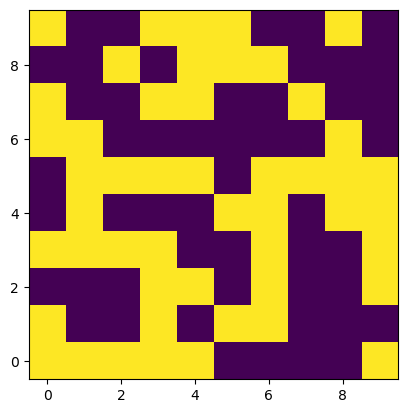

In [259]:
plt.imshow(canvas.to(cpu), origin="lower")

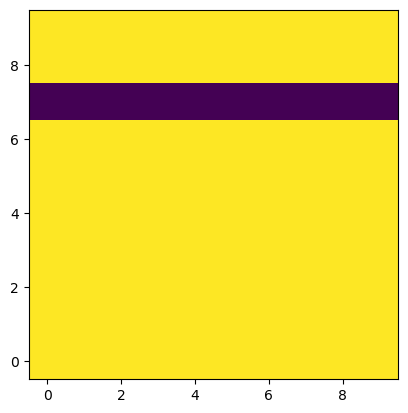

In [258]:
plt.imshow(new_canvas.to(cpu), origin="lower")

In [ ]:
torch.inverse

In [233]:
(envsum == check1).type(torch.int)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [221]:
envsum == check1

tensor([[ True,  True,  True, False, False,  True, False, False, False, False],
        [False,  True,  True,  True, False, False,  True, False, False,  True],
        [ True, False,  True, False, False, False,  True, False, False, False],
        [False, False,  True,  True,  True,  True,  True, False,  True,  True],
        [ True,  True, False,  True,  True, False, False, False,  True, False],
        [ True, False,  True,  True, False, False,  True,  True, False,  True],
        [ True,  True,  True,  True,  True, False, False, False, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True, False],
        [ True, False, False, False, False, False, False,  True, False, False],
        [False, False,  True, False, False,  True,  True, False, False, False]],
       device='cuda:0')

In [219]:
id1

tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]], device='cuda:0')

In [ ]:
#     Any live cell with two or three live neighbours lives on to the next generation.
canvas - 2

In [215]:
(envsum == 2).is_nonzero

tensor([[ True,  True,  True, False, False,  True, False, False, False, False],
        [False,  True,  True,  True, False, False,  True, False, False,  True],
        [ True, False,  True, False, False, False,  True, False, False, False],
        [False, False,  True,  True,  True,  True,  True, False,  True,  True],
        [ True,  True, False,  True,  True, False, False, False,  True, False],
        [ True, False,  True,  True, False, False,  True,  True, False,  True],
        [ True,  True,  True,  True,  True, False, False, False, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True, False],
        [ True, False, False, False, False, False, False,  True, False, False],
        [False, False,  True, False, False,  True,  True, False, False, False]],
       device='cuda:0')

In [209]:
ind = torch.where(envsum, , "=")

TypeError: where() received an invalid combination of arguments - got (Tensor, int, str), but expected one of:
 * (Tensor condition)
 * (Tensor condition, Tensor input, Tensor other, *, Tensor out)
 * (Tensor condition, Number self, Tensor other)
      didn't match because some of the arguments have invalid types: (Tensor, !int!, !str!)
 * (Tensor condition, Tensor input, Number other)
      didn't match because some of the arguments have invalid types: (Tensor, !int!, !str!)
 * (Tensor condition, Number self, Number other)
      didn't match because some of the arguments have invalid types: (Tensor, !int!, !str!)


In [205]:
torch.sign(envsum - 2)

tensor([[ 0,  0,  0,  1, -1,  0, -1, -1, -1, -1],
        [-1,  0,  0,  0,  1, -1,  0, -1, -1,  0],
        [ 0, -1,  0,  1, -1,  1,  0, -1, -1, -1],
        [-1,  1,  0,  0,  0,  0,  0, -1,  0,  0],
        [ 0,  0,  1,  0,  0, -1,  1,  1,  0,  1],
        [ 0,  1,  0,  0, -1,  1,  0,  0,  1,  0],
        [ 0,  0,  0,  0,  0, -1, -1,  1, -1,  0],
        [-1,  0,  0, -1,  0,  0,  0, -1,  0, -1],
        [ 0, -1, -1,  1,  1,  1, -1,  0, -1, -1],
        [-1, -1,  0, -1,  1,  0,  0, -1, -1, -1]], device='cuda:0')